# Convert Videos to Frames and create COCO Annotations

The Fall Dataset from ImVia (https://imvia.u-bourgogne.fr/en/database/fall-detection-dataset-2.html) was taken since the videos are annotated with defined bounding boxes and no manual labelling needs to be done. However, the annotations are not in a COCO annotation format. For this frames will be created and matched with the annotation file to calculate the bounding box format and category needed for the COCO annotation format.

## Mount Google Drive

To start with the Google drive needs to be mounted.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set up Libraries & Paths

Afterwards the libraries need to be installed and the runtime needs to be restarted when finished.

In [ ]:
# Install libraries if necessary
!pip3 install opencv-python
!pip install sahi
!pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 3.5 MB/s 
     |████████████████████████████████| 87 kB 7.2 MB/s 
     |████████████████████████████████| 60.5 MB 137 kB/s 
     |████████████████████████████████| 3.1 MB 56.4 MB/s 
     |████████████████████████████████| 97 kB 7.2 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=15f196242fd0eca868c83be50222ed92ac87bb4c7f02e9eeb1b3cfddfc7950ba
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


After the restart of the runtime the libraries can be imported.

In [ ]:
# Import libraries
import shutil
import cv2
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
from sahi.utils.coco import Coco, CocoCategory, CocoImage, CocoAnnotation
from sahi.utils.file import save_json
from pycocotools.coco import COCO
from google.colab import files

The fall dataset can be loaded and unzipped, however it is too big for Google Colab, so it is advised to upload the unzipped folders manually one by one to a folder in Google Colab. In this case the folder "ImViaFallDataset" was created and the unzipped folders "Coffee_room_01", "Coffee_room_02", "Home_01" and "Home_02" that contain videos and annotation files were uploaded as well as the folders "Lecture room" and "Office" that only contain videos and no annotations and can therefore be used as test videos.

In [ ]:
# Download and unzip dataset -- careful, might be too big!!! Create folder and upload unzipped folder manually
zipurl = 'http://imvia.u-bourgogne.fr/database/FallDataset.zip'
with urlopen(zipurl) as zipresp:
      with ZipFile(BytesIO(zipresp.read())) as zfile:
          zfile.extractall('/content/drive/MyDrive/MasterThesis/NanoDet/FallDataset')

In the following the video and annotation paths for the unzipped folders from the ImVia fall dataset are defined. In addition a common path for all videos and annotations as well as the paths for the frames that will be created from the videos are defined for training, validation and test images are defined. The COCO annotations paths as well as the names of the .json files that will be created are also set.

In [ ]:
# Define paths

# Path where the videos of the dataset are stored after extraction of .zip
src_path_c1 = '/content/drive/MyDrive/MasterThesis/FallDataset/ImViaFallDataset/Coffee_room_01/Videos'
src_path_c2 = '/content/drive/MyDrive/MasterThesis/FallDataset/ImViaFallDataset/Coffee_room_02/Videos'
src_path_h1 = '/content/drive/MyDrive/MasterThesis/FallDataset/ImViaFallDataset/Home_01/Videos'
src_path_h2 = '/content/drive/MyDrive/MasterThesis/FallDataset/ImViaFallDataset/Home_02/Videos'
src_path_l = '/content/drive/MyDrive/MasterThesis/FallDataset/ImViaFallDataset/Lecture room'
src_path_o = '/content/drive/MyDrive/MasterThesis/FallDataset/ImViaFallDataset/Office'

# New source pathes for annotaed and not annotated videos (will be created if not exist!)
src_path = '/content/drive/MyDrive/MasterThesis/FallDataset/Videos'

# Path where the frames shall be stored (will be created if not exist!)
to_path = '/content/drive/MyDrive/MasterThesis/FallDataset/AllFrames'
to_train_path = '/content/drive/MyDrive/MasterThesis/FallDataset/TrainingFrames'
to_val_path = '/content/drive/MyDrive/MasterThesis/FallDataset/ValidationFrames'
to_test_path = '/content/drive/MyDrive/MasterThesis/FallDataset/TestFrames'

# Path where annotations from dataset are stored
annotation_path_c1 = '/content/drive/MyDrive/MasterThesis/FallDataset/ImViaFallDataset/Coffee_room_01/Annotation_files'
annotation_path_c2 = '/content/drive/MyDrive/MasterThesis/FallDataset/ImViaFallDataset/Coffee_room_02/Annotations_files'
annotation_path_h1 = '/content/drive/MyDrive/MasterThesis/FallDataset/ImViaFallDataset/Home_01/Annotation_files'
annotation_path_h2 = '/content/drive/MyDrive/MasterThesis/FallDataset/ImViaFallDataset/Home_02/Annotation_files'

# New source path for annotion files (will be created if not exist!)
annotation_path = '/content/drive/MyDrive/MasterThesis/FallDataset/Annotation_files'

# Path and file where COCO annotation .json file will be stored
json_path = '/content/drive/MyDrive/MasterThesis/FallDataset/CocoAnnotations'
save_json_path = '/content/drive/MyDrive/MasterThesis/FallDataset/CocoAnnotations/CocoAnnotation.json'
save_json_train_path = '/content/drive/MyDrive/MasterThesis/FallDataset/CocoAnnotations/CocoAnnotation_train.json'
save_json_val_path = '/content/drive/MyDrive/MasterThesis/FallDataset/CocoAnnotations/CocoAnnotation_val.json'

## Creation of Common folders

In order to create a COCO annotation file for all videos, the videos will first be renamed as they have the same names in different folders. The "Coffee_room" videos will receive a "c_" before their name and the "Home" videos a "h_", the "Lecture room" a "l_" and the "Office" videos will get a "o_".

In [ ]:
# Change Video names for identification when moved to common folder

# Creation of dictionary for renaming video files
src_dict = {'src_path_c1':[src_path_c1,'c_'],'src_path_c2':[src_path_c2,'c_'],'src_path_h1':[src_path_h1,'h_'],'src_path_h2':[src_path_h2,'h_'],'src_path_l':[src_path_l,'l_'],'src_path_o':[src_path_o,'o_']}

for key, values in src_dict.items():       
    files = os.listdir(values[0])
    for index, file in enumerate(files):
        os.rename(os.path.join(values[0], file), os.path.join(values[0], ''.join([values[1],file])))  

After renaming the videos, they are copied to the common folder.

In [ ]:
# Copying Video files to common folder
try:
    # Create target folder
    if not os.path.exists(os.path.join(src_path)):
        os.makedirs(os.path.join(src_path))

# If target folder could not be created/found show error
except OSError:
    print ('Error: Creating directory of' + os.path.join(src_path))
    
# Creation of dictionary for moving video files
src_dict_path = {'src_path_c1':src_path_c1,'src_path_c2':src_path_c2,'src_path_h1':src_path_h1,'src_path_h2':src_path_h2,'src_path_l':src_path_l,'src_path_o':src_path_o}

for key, values in src_dict_path.items():       
    files = os.listdir(values)
    for index, file in enumerate(files):
        shutil.copy(os.path.join(values,file), src_path)

The same applies to the annotation files. However, the "Lecture room" and the "Office" videos do not have annotations.

In [ ]:
# Change Annotation names for identification when moved to common folder

# Creation of dictionary for renaming annotation files
annotation_dict = {'annotation_path_c1':[annotation_path_c1,'c_'],'annotation_path_c2':[annotation_path_c2,'c_'],'annotation_path_h1':[annotation_path_h1,'h_'],'annotation_path_h2':[annotation_path_h2,'h_']}

for key, values in annotation_dict.items():       
    files = os.listdir(values[0])
    for index, file in enumerate(files):
        os.rename(os.path.join(values[0], file), os.path.join(values[0], ''.join([values[1],file])))  

After renaming, the annotation files are moved to the common annotation folder.

In [ ]:
# Copying Annotation files to common folder
try:
    # Create target folder
    if not os.path.exists(os.path.join(annotation_path)):
        os.makedirs(os.path.join(annotation_path))

# If target folder could not be created/found show error
except OSError:
    print ('Error: Creating directory of' + os.path.join(annotation_path))
    
# Creation of dictionary for moving annotation files
annotation_dict_path = {'annotation_path_c1':annotation_path_c1,'annotation_path_c2':annotation_path_c2,'annotation_path_h1':annotation_path_h1,'annotation_path_h2':annotation_path_h2}

for key, values in annotation_dict_path.items():       
    files = os.listdir(values)
    for index, file in enumerate(files):
        shutil.copy(os.path.join(values,file), annotation_path)

## Overview of Videos

To make sure all videos are being moved to the common folders, the elements are counted. The number of elements should be 190 videos in total.

In [ ]:
videos = os.listdir(src_path)

# Count all elements in source path
def get_no_of_elements(videos):
    count = 0
    for element in videos:
        count += 1
    return count

elements = get_no_of_elements(videos)
print('Number of elements in the list: ', get_no_of_elements(videos))

Number of elements in the list:  190


To observe naming of the videos, the names can be printed.

In [ ]:
# Show contents of list
print(videos)

['c_video (1).avi', 'c_video (10).avi', 'c_video (11).avi', 'c_video (12).avi', 'c_video (13).avi', 'c_video (14).avi', 'c_video (15).avi', 'c_video (16).avi', 'c_video (17).avi', 'c_video (18).avi', 'c_video (19).avi', 'c_video (2).avi', 'c_video (20).avi', 'c_video (21).avi', 'c_video (22).avi', 'c_video (23).avi', 'c_video (24).avi', 'c_video (25).avi', 'c_video (26).avi', 'c_video (27).avi', 'c_video (28).avi', 'c_video (29).avi', 'c_video (3).avi', 'c_video (30).avi', 'c_video (31).avi', 'c_video (32).avi', 'c_video (33).avi', 'c_video (34).avi', 'c_video (35).avi', 'c_video (36).avi', 'c_video (37).avi', 'c_video (38).avi', 'c_video (39).avi', 'c_video (4).avi', 'c_video (40).avi', 'c_video (41).avi', 'c_video (42).avi', 'c_video (43).avi', 'c_video (44).avi', 'c_video (45).avi', 'c_video (46).avi', 'c_video (47).avi', 'c_video (48).avi', 'c_video (5).avi', 'c_video (6).avi', 'c_video (7).avi', 'c_video (8).avi', 'c_video (9).avi', 'c_video (49).avi', 'c_video (50).avi', 'c_video

The following code can be used for showing a video when executing the notebook on a local computer. However it does not work with Google Colab since it requires to open a new python window. The code will be kept only as reference.

In [ ]:
# Look at video (1) in a new frame
cap = cv2.VideoCapture(os.path.join(src_path,videos[1]))

# Check if camera opened
if (cap.isOpened()== False): 
  print('Error opening video stream or file')

# Read until video is completed
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret == True:

    # Display frame
    cv2.imshow('Frame',frame)
    
    # Press Q on keyboard to quit
    if cv2.waitKey(25) & 0xFF == ord('q'):
      break

  # Break the loop
  else: 
    break

# Release the video capture object
cap.release()

# Closes all frames
cv2.destroyAllWindows()

## Creation of Frames

The videos from the common folder need to be split into frames of images. The frames will be stored to the path for later training frames, except if they belong to the "Lecture room" or "Office" videos without annotations. Those will be stored to the test path for testing frames.

In [ ]:
# Create to path for frames
try:
    # Create target folder
    if not os.path.exists(os.path.join(to_path)):
        os.makedirs(os.path.join(to_path))

# If target folder could not be created/found show error
except OSError:
    print ('Error: Creating directory of' + os.path.join(to_path))

# Create to path for test frames (viedos that have no annotations)
try:
    # Create target folder
    if not os.path.exists(os.path.join(to_test_path)):
        os.makedirs(os.path.join(to_test_path))

# If target folder could not be created/found show error
except OSError:
    print ('Error: Creating directory of' + os.path.join(to_test_path))    
       

# For all viedos in source folder create frames
for i in range(elements):
    
    from_path = os.path.join(src_path,videos[i])
    name_video = videos[i].split('.')[0]
    
    # Read the video from specified path
    cam = cv2.VideoCapture(os.path.join(from_path))

    # frame
    currentframe = 1

    while(True):

        # Read frame
        ret,frame = cam.read()

        if ret:
            # If video is not finished go on creating images
            
            # Send training and test image frames to different folders
            if  name_video[0] in ('l','o'):
                name = os.path.join(to_test_path) + '/' + name_video + ' frame ' + str(currentframe) + '.png'
                print ('Creating...' + name)
                
                 # Write extracted images to target path
                cv2.imwrite(name, frame)
            else:
                name = os.path.join(to_path) + '/' + name_video + ' frame ' + str(currentframe) + '.png'
                print ('Creating...' + name)

                # Write extracted images to target path
                cv2.imwrite(name, frame)

            # Increase counter
            currentframe += 1
        else:
            break

    # Release all space and windows when done
    cam.release()
    cv2.destroyAllWindows()

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Creating.../content/drive/MyDrive/MasterThesis/FallDataset/TestFrames/o_video (29) frame 1137.png
Creating.../content/drive/MyDrive/MasterThesis/FallDataset/TestFrames/o_video (29) frame 1138.png
Creating.../content/drive/MyDrive/MasterThesis/FallDataset/TestFrames/o_video (29) frame 1139.png
Creating.../content/drive/MyDrive/MasterThesis/FallDataset/TestFrames/o_video (29) frame 1140.png
Creating.../content/drive/MyDrive/MasterThesis/FallDataset/TestFrames/o_video (29) frame 1141.png
Creating.../content/drive/MyDrive/MasterThesis/FallDataset/TestFrames/o_video (29) frame 1142.png
Creating.../content/drive/MyDrive/MasterThesis/FallDataset/TestFrames/o_video (29) frame 1143.png
Creating.../content/drive/MyDrive/MasterThesis/FallDataset/TestFrames/o_video (29) frame 1144.png
Creating.../content/drive/MyDrive/MasterThesis/FallDataset/TestFrames/o_video (29) frame 1145.png
Creating.../content/drive/MyDrive/MasterThesis/Fall

To make sure the required paths are created, the contents of the drive can be loaded.

In [ ]:
!ls '/content/drive/MyDrive/MasterThesis/FallDataset'

AllFrames	  ImViaFallDataset  TestFrames		 Videos
Annotation_files  README.txt	    URFallDatasetSample


Check whether 42.066 frames have been created in the training folder.

In [ ]:
frames = os.listdir(to_path)

# Count all elements in to path
def get_no_of_elements(frames):
    count = 0
    for element in frames:
        count += 1
    return count

elements = get_no_of_elements(frames)
print('Number of elements in the list: ', get_no_of_elements(frames))

Number of elements in the list:  42066


## Create COCO Annotations

The COCO annotation format requires the image name and path information as well as the according bounding box with the upper-left coordinates and the width and height. In addition the category "fall" or "activities of daily living (adl)" is required. 

The annotations provided per video contain as first two rows start and end frame of the fall in the video. The following rows are described to contain the frame number, a number that is not described in the readme by the authors, the height, the width, and the center coordinates of the boundary boxes. However, looking at the bounding boxes this description is not right: The four numbers actually contain the top left x and y coordinates and the bottom right x and y coordinates. Since the COCO annotations require the width and the height, these two have to be calculated.

In [ ]:
# Define coco and add the two categories
coco = Coco()
coco.add_category(CocoCategory(id=1, name='fall'))
coco.add_category(CocoCategory(id=2, name='adl'))

Since the annotation of videos c_video (26), c_video (50) and c_video (52) have fall_start and fall_end in the middle, instead of in the first two rows and videos c_video (35), h_video (2), h_video (5-7), h_video (9), h_video (12), h_video (14), h_video (16 - 23), h_video (25 - 28), h_video (30-37), h_video (40-43) and h_video (45-60) have multiple entries at the end that need to be deleted, these csv files are opened manually and are corrected. Afterwards the annotations can be added to the COCO format for each frame of each video.

It can be chosen whether the fall itself or the result of the fall (e.g. lying on the floor) shall be classified as fall. In the later case the frames showing a classified fall will increase from 2.378 to 20.613 images!

In [ ]:
# Get the count of annotations
annotations = os.listdir(annotation_path)

def get_no_of_elements(annotations):
    count = 0
    for element in annotations:
        count += 1
    return count

annotation_elements = get_no_of_elements(annotations)

# Get the start, end information from text file for each video
for i in range(annotation_elements):

    video_num = annotations[i].replace('.txt','')
    print('Number of video for annotation: ',video_num)
    ann_path = os.path.join(annotation_path + '/' + annotations[i])
    fall_start_end = pd.read_csv(ann_path, nrows=2, header=None)
    fall_start = fall_start_end.loc[0].values
    fall_end = fall_start_end.loc[1].values
    
    cols = ['FrameID','Unkown','TopX','TopY','BottomX', 'BottomY']
    df_bbox = pd.read_csv(ann_path, header=1, names=cols)
    df_bbox['video_src'] = annotations[i][0]

    frames = os.listdir(to_path)
    video_frame_num = []

    # Get the number of frames of each video
    def get_elements(frames):
        count = 0
        for element in frames:
            if video_num in element:
                video_frame_num.append(element)
                count += 1
        return count, video_frame_num

    elements, video_frame_num = get_elements(frames)

    # Set bounding box information for each frame
    for i in range(elements):
        path = os.path.join(to_path + '/' + video_frame_num[i])
        #print(video_frame_num[i])
        coco_image = CocoImage(file_name=os.path.join(path), height=240, width=320)
        frame_no = int(video_frame_num[i].replace('.png','').split()[-1])
        #print(frame_no)
        frame_top_left_x_null = int(df_bbox.loc[(df_bbox['FrameID'] == frame_no) & (df_bbox['video_src'] == video_frame_num[i][0]), 'TopX']) 
        frame_top_left_x = frame_top_left_x_null if frame_top_left_x_null > 1 else 1
        frame_top_left_y_null = int(df_bbox.loc[(df_bbox['FrameID'] == frame_no) & (df_bbox['video_src'] == video_frame_num[i][0]), 'TopY'])
        frame_top_left_y = frame_top_left_y_null if frame_top_left_y_null > 1 else 1
        frame_width_null = int(df_bbox.loc[(df_bbox['FrameID'] == frame_no) & (df_bbox['video_src'] == video_frame_num[i][0]), 'BottomX']) - frame_top_left_x 
        frame_width = frame_width_null if frame_width_null > 1 else 1
        frame_height_null = int(df_bbox.loc[(df_bbox['FrameID'] == frame_no) & (df_bbox['video_src'] == video_frame_num[i][0]), 'BottomY']) - frame_top_left_y
        frame_height = frame_height_null if frame_height_null > 1 else 1

        # For detecting fall from start to end:
        if frame_no < fall_start or frame_no > fall_end:
        
        # For detecting fall after end when person is lying on floor:
        #if frame_no < fall_end:

            cat_id = 2
            cat_name = 'adl'
        else:
            cat_id = 1
            cat_name = 'fall'
        coco_image.add_annotation(
          CocoAnnotation(
          bbox=[frame_top_left_x, frame_top_left_y, frame_width, frame_height],
          category_id=cat_id,
          category_name=cat_name
          )
        )
        coco.add_image(coco_image)

Number of video for annotation:  c_video (1)
Number of video for annotation:  c_video (24)
Number of video for annotation:  c_video (17)
Number of video for annotation:  c_video (13)
Number of video for annotation:  c_video (20)
Number of video for annotation:  c_video (14)
Number of video for annotation:  c_video (19)
Number of video for annotation:  c_video (21)
Number of video for annotation:  c_video (15)
Number of video for annotation:  c_video (28)
Number of video for annotation:  c_video (29)
Number of video for annotation:  c_video (12)
Number of video for annotation:  c_video (11)
Number of video for annotation:  c_video (16)
Number of video for annotation:  c_video (22)
Number of video for annotation:  c_video (25)
Number of video for annotation:  c_video (2)
Number of video for annotation:  c_video (18)
Number of video for annotation:  c_video (23)
Number of video for annotation:  c_video (10)
Number of video for annotation:  c_video (27)
Number of video for annotation:  c_v

If the folder for storing the annotation does not exists, it will be created and the COCO annotations can be stored in the defined folder and file.

In [ ]:
# Create folder for COCO annotations
try:
    # Create target folder
    if not os.path.exists(os.path.join(json_path)):
        os.makedirs(os.path.join(json_path))

# If target folder could not be created/found show error
except OSError:
    print ('Error: Creating directory of' + os.path.join(json_path))

# Save the COCO annotations into .json file
save_json(data=coco.json, save_path= save_json_path)

Since Google colab is soemtimes not working as expected the file is being downloaded.

In [ ]:
files.download(save_json_path) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Show example image of created frames

To check that the COCO annotation file has been created accurately a random image can be looked upon and shown with the corresponding bounding box and category.

In [ ]:
# Load picture for any id and print file name for reference
coco = COCO(save_json_path)
imgId = coco.getImgIds(130)
imgIds = coco.loadImgs(imgId)
print(imgIds)
for file in imgIds:
    file_name = file['file_name']
image = plt.imread(file_name)

loading annotations into memory...
Done (t=1.20s)
creating index...
index created!
[{'height': 240, 'width': 320, 'id': 130, 'file_name': '/content/drive/MyDrive/MasterThesis/FallDataset/AllFrames/c_video (1) frame 130.png'}]


In [ ]:
# Show information of image
annotation_ids = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annotation_ids)
print(anns)

[{'iscrowd': 0, 'image_id': 130, 'bbox': [75, 130, 124, 76], 'segmentation': [], 'category_id': 2, 'id': 130, 'area': 9424}]


In [ ]:
# Show only information of bounding box
for ann in anns:
    print(ann['bbox'])

[75, 130, 124, 76]


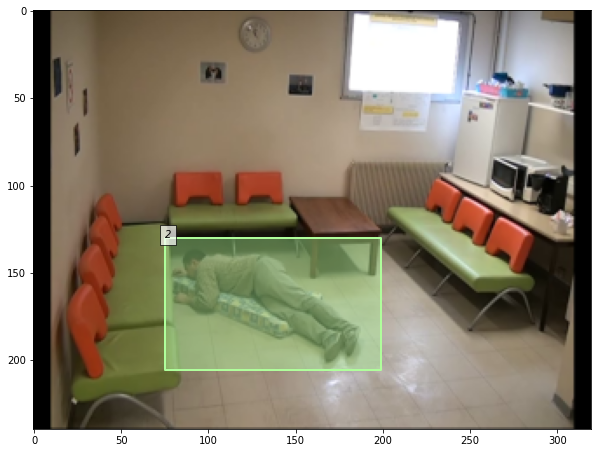

In [ ]:
# Display image with bounding box
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image)
COCO.showAnns(image, anns, draw_bbox=True)
for i, ann in enumerate(anns):
    ax.text(anns[i]['bbox'][0], anns[i]['bbox'][1], anns[i]['category_id'], style='italic', 
            bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})

## Show distribution of categories

In order to prevent overfitting of the model, the amount of images with falls and adl should be ideally euqal. To find out how many fall and how many adl images have been created, the count for each category is checked.

In [ ]:
fall_imgs = coco.getImgIds(catIds=[1])
count_falls = len(fall_imgs)

adl_imgs = coco.getImgIds(catIds=[2])
count_adls = len(adl_imgs)
print('Number of images with category fall: ', count_falls)
print('Number of images with category adl: ', count_adls)

Number of images with category fall:  2378
Number of images with category adl:  39688


Since there are only 2.378 fall images and 39.688 adl images, either the fall images need to be upsampled - for example by mirroring them, since rotation of falls could lead to unreal training examples - or the adl images have to be downsampled. 

Considering the limited training time and the sufficient number of fall images, the adl categories will be downsampled for this study.

## Downsampling of adl category

A random choice of adl images with the same number of fall images is taken.

In [ ]:
# Select a random sample of adl category images with same number of fall category images in order not to overfit training
import random
random.seed(8888)

keep_adl_imgs = random.sample(adl_imgs, count_falls)
print(len(keep_adl_imgs))

2378


A list is created with the image ids of the adl category that can be deleted.

In [ ]:
# Create a list with adl images to delete from annotation file
set_keep = set(keep_adl_imgs)
delete_adl_imgs = [x for x in adl_imgs if x not in set_keep]
print(len(delete_adl_imgs))

37310


A list with the corresponding image paths is created in order to be able to delte the not used images later.

In [ ]:
# Create a list with adl image paths to delete from directory
delete_adl_imgs_files = []
img_delete_Ids = coco.loadImgs(delete_adl_imgs)
for file in img_delete_Ids:
    file_name = file['file_name']
    delete_adl_imgs_files.append(file_name)
print(len(delete_adl_imgs_files)) 

37310


A new COCO annotation file is created by assembly of three dictionaries containing the images, the annotations and the categories of the remaining fall and adl images. It then overwrites the original COCO annotation file which is no longer of use.

In [ ]:
# Delete adl images from annoation file

# Open json file
with open(save_json_path, 'r+') as data_file:
    obj = json.load(data_file)

# Create dictionary list of kept images
images = obj['images']
df_img = pd.DataFrame.from_dict(images)
df_img_del = df_img[~df_img.id.isin(delete_adl_imgs)]
dict_img = list(df_img_del.T.to_dict().values())

# Create dictionary list of kept annotation
annotations = obj['annotations']
df_ann = pd.DataFrame.from_dict(annotations)
df_ann_del = df_ann[~df_ann.image_id.isin(delete_adl_imgs)]
dict_ann = list(df_ann_del.T.to_dict().values())

# Create dictionary list of categories
categories = obj['categories']
df_cats = pd.DataFrame.from_dict(categories)
dict_cats = list(df_cats.T.to_dict().values())

# Create new dictionary out of the three lists
new_dict = {}
new_dict = {"images": dict_img, "annotations": dict_ann, "categories": dict_cats}

# Overwrite old annotation file
with open(save_json_path, 'w') as f:
    json.dump(new_dict, f, indent=2)
print("New json file with equal sample count for fall and adl has been created.")

New json file with equal sample count for fall and adl has been created.


Again download the new annotation file.

In [ ]:
files.download(save_json_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Afterwards the annotation file contains an equal number of fall and adl images.

In [ ]:
# Check whether categories have the same number of images now
coco = COCO(save_json_path)

fall_imgs = coco.getImgIds(catIds=[1])
count_falls = len(fall_imgs)

adl_imgs = coco.getImgIds(catIds=[2])
count_adls = len(adl_imgs)
print('Number of images with category fall: ', count_falls)
print('Number of images with category adl: ', count_adls)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Number of images with category fall:  2378
Number of images with category adl:  2378


The frames for training are moved to the training folder.

In [ ]:
# Copy images to training folder
try:
    # Create target folder
    if not os.path.exists(os.path.join(to_train_path)):
        os.makedirs(os.path.join(to_train_path))

# If target folder could not be created/found show error
except OSError:
    print ('Error: Creating directory of' + os.path.join(to_train_path))
    
# Creation of list for moving training images
list_train = list(df_img_del['file_name'])

for file_name in list_train:
    full_file_name = file_name
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, to_train_path)

In [ ]:
!ls '/content/drive/MyDrive/MasterThesis/FallDataset/'

AllFrames	  CocoAnnotations   README.txt	TrainingFrames	     Videos
Annotation_files  ImViaFallDataset  TestFrames	URFallDatasetSample


Check if 4.756 files are copied to the training folder.

In [ ]:
frames = os.listdir(to_train_path)

# Count all elements in to path
def get_no_of_elements(frames):
    count = 0
    for element in frames:
        count += 1
    return count

elements = get_no_of_elements(frames)
print('Number of elements in the list: ', get_no_of_elements(frames))

Number of elements in the list:  4756


## Split Training and Validation Set

To ensure an unbiased assessment of the model fit to the training dataset while tuning the model's hyperparameters, a validation dataset is necessary. The Nanodet model requires separate COCO annotation files and image folders since it does not split the training dataset by itself. Hence in the following section the sets will be created.

Since the dataset for training contains over 4.000 images, 1.000 random images are taken out of the training data for creation of the validation dataset.

In [ ]:
# Select a random sample of both categories to create validation data of around 20% of image data
import random
random.seed(8888)

val_imgs = []
val_adl_imgs = []

val_imgs = random.sample(fall_imgs, 500)
val_adl_imgs = random.sample(adl_imgs, 500)

val_imgs.extend(val_adl_imgs)
print(len(val_imgs))

1000


A list with the training images that are left ist created.

In [ ]:
# Create a list with training image data only
all_imgs = coco.getImgIds()
set_val = set(val_imgs)
train_imgs = [x for x in all_imgs if x not in val_imgs]
print(len(train_imgs))

3756


A new COCO annotation file is created by assembly of three dictionaries containing the images, the annotations and the categories of the validation images.

In [ ]:
# Create validation annotation file

# Open json file
with open(save_json_path, 'r+') as data_file:
    obj = json.load(data_file)

# Load val images
images = obj['images']
df_img = pd.DataFrame.from_dict(images)
df_img_val = df_img[df_img.id.isin(val_imgs)]

# Replacing path with validation path
df_img_val = df_img_val.set_index(['file_name'])  
df_img_val = df_img_val.reset_index()
df_img_val['file_name'] = df_img_val['file_name'].str.replace(to_path, to_val_path)

# Create dictionary list of val images
dict_img_val = list(df_img_val.T.to_dict().values())

# Create dictionary list of val annotation
annotations = obj['annotations']
df_ann = pd.DataFrame.from_dict(annotations)
df_ann_val = df_ann[df_ann.image_id.isin(val_imgs)]
dict_ann_val = list(df_ann_val.T.to_dict().values())

# Create dictionary list of categories
categories = obj['categories']
df_cats_val = pd.DataFrame.from_dict(categories)
dict_cats_val = list(df_cats_val.T.to_dict().values())

# Create new dictionary out of the three lists
val_dict = {}
val_dict = {"images": dict_img_val, "annotations": dict_ann_val, "categories": dict_cats_val}

# Overwrite old annotation file
with open(save_json_val_path, 'w') as f:
    json.dump(val_dict, f, indent=2)
print("New json file with annotations for validation has been created.")

New json file with annotations for validation has been created.


The images used for validation are the moved from the training frames folder to the validation frames folder.

In [ ]:
# Move images to validation folder
try:
    # Create target folder
    if not os.path.exists(os.path.join(to_val_path)):
        os.makedirs(os.path.join(to_val_path))

# If target folder could not be created/found show error
except OSError:
    print ('Error: Creating directory of' + os.path.join(to_val_path))

# Replacing path with actual training path as from path
df_img_val = df_img_val.set_index(['file_name'])  
df_img_val = df_img_val.reset_index()
df_img_val['file_name'] = df_img_val['file_name'].str.replace(to_val_path, to_train_path)
    
# Creation of list for moving validation images
list_val = list(df_img_val['file_name'])

for file_name in list_val:
    full_file_name = file_name
    if os.path.isfile(full_file_name):
        shutil.move(full_file_name, to_val_path)

Check whether the 1.000 images are in the validation folder.

In [ ]:
frames = os.listdir(to_val_path)

# Count all elements in to path
def get_no_of_elements(frames):
    count = 0
    for element in frames:
        count += 1
    return count

elements = get_no_of_elements(frames)
print('Number of elements in the list: ', get_no_of_elements(frames))

Number of elements in the list:  1000


A new COCO annotation file is created by assembly of three dictionaries containing the images, the annotations and the categories of the training images.

In [ ]:
# Create annotation file with train images only

# Open json file
with open(save_json_path, 'r+') as data_file:
    obj = json.load(data_file)

# Load train images
images = obj['images']
df_img = pd.DataFrame.from_dict(images)
df_img_train = df_img[df_img.id.isin(train_imgs)]

# Replacing path with validation path
df_img_train = df_img_train.set_index(['file_name'])  
df_img_train = df_img_train.reset_index()
df_img_train['file_name'] = df_img_train['file_name'].str.replace(to_path, to_train_path)

# Create dictionary list of train images
dict_img_train = list(df_img_train.T.to_dict().values())

# Create dictionary list of train annotation
annotations = obj['annotations']
df_ann = pd.DataFrame.from_dict(annotations)
df_ann_train = df_ann[df_ann.image_id.isin(train_imgs)]
dict_ann_train = list(df_ann_train.T.to_dict().values())

# Create dictionary list of categories
categories = obj['categories']
df_cats_train = pd.DataFrame.from_dict(categories)
dict_cats_train = list(df_cats_train.T.to_dict().values())

# Create new dictionary out of the three lists
train_dict = {}
train_dict = {"images": dict_img_train, "annotations": dict_ann_train, "categories": dict_cats_train}

# Overwrite old annotation file
with open(save_json_train_path, 'w') as f:
    json.dump(train_dict, f, indent=2)
print("New json file with annotations for training has been created.")

New json file with annotations for training has been created.


Check whether the folder has been created.

In [ ]:
!ls '/content/drive/MyDrive/MasterThesis/FallDataset/'

AllFrames	  ImViaFallDataset  TrainingFrames	 Videos
Annotation_files  README.txt	    URFallDatasetSample
CocoAnnotations   TestFrames	    ValidationFrames


Finally check that the number of training and validation images matches 4.756 images in total (3.756 training and 1.000 validation images).

In [ ]:
# Check how many training images are annotated
coco = COCO(save_json_train_path)

all_train_imgs = coco.getImgIds()
count_train_imgs = len(all_train_imgs)

print('Number of training images: ', count_train_imgs)

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Number of training images:  3756


In [ ]:
# Check how many validation images are annotated
coco = COCO(save_json_val_path)

all_val_imgs = coco.getImgIds()
count_val_imgs = len(all_val_imgs)

print('Number of validation images: ', count_val_imgs)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of validation images:  1000
